# Quick Start: scGPT

This quick start will guide you through using the scGPT model, trained on 33 million cells (including data from the CELLxGENE Census), to generate embeddings for single-cell transcriptomic data analysis.

## Learning Goals
By the end of this tutorial, you will understand how to:
1. Access and prepare the scGPT model for use.
2. Generate embeddings to analyze and compare your dataset against the CELLxGENE Census.
3. Visualize the results using a UMAP, colored by cell type.

## Pre-requisites and Requirements
Before starting, ensure you are familiar with:
- **Python** and **AnnData**
- **Single-cell data analysis** ([see this tutorial for a primer on the subject](https://broadinstitute.github.io/2020_scWorkshop/))  
You can run this tutorial locally (tested on an M3 MacBook with 32 GiB memory) or in Google Colab using a T4 instance. Environment setup will be covered in a later section.

## Overview
This notebook provides a step-by-step guide to:
1. Setting up your environment
2. Downloading the necessary model checkpoints and h5ad dataset
3. Performing model inference to create embeddings
4. Visualizing the results with UMAP

## Setup

In [ ]:
%%capture [--no-stderr]
!pip install uv==0.6.12
!UV_BUILD_CONSTRAINT="" UV_CONSTRAINT="" uv pip install --system torchvision==0.16.2 torch==2.1.2 scgpt scanpy gdown numpy==1.26.4

## At this point you need to restart your environment in order to load the correct versions of torch and numpy

You can do this by clicking `Runtime -> Restart Session` or pressing `CTRL/CMD(MacOS) + M + .`

Then after the session restarts run the rest of the cells below:

In [ ]:
!pip show scgpt

Name: scgpt
Version: 0.2.4
Summary: Large-scale generative pretrain of single cell using transformer.
Home-page: https://github.com/bowang-lab/scGPT
Author: Haotian
Author-email: subercui@gmail.com
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: cell-gears, datasets, leidenalg, numba, orbax, pandas, scanpy, scib, scikit-misc, scvi-tools, torch, torchtext, typing-extensions, umap-learn
Required-by: 


We can install the rest of our dependencies and import the relevant libraries.

In [ ]:
# Import libraries

import warnings
import urllib.request
from pathlib import Path

import scgpt as scg
import scanpy as sc
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/usr/local/lib/python3.11/dist-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


*If at this point you get a numpy version error, you may need to restart the session (see above).* Otherwise, we are ready to run the models

## Download Model Checkpoints and Data

Let's download the checkpoints from [the scGPT repository](https://github.com/bowang-lab/scGPT?tab=readme-ov-file#pretrained-scgpt-model-zoo).

In [ ]:
# Filter warnings

warnings.simplefilter("ignore", ResourceWarning)
warnings.filterwarnings("ignore", category=ImportWarning)

# Use gdown with the recursive flag to download the folder
# Replace the folder ID with the ID of your folder
folder_id = '1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y'

# Download the folder and its contents recursively
!gdown --folder {folder_id}

Retrieving folder contents
Processing file 1hh2zGKyWAx3DyovD30GStZ3QlzmSqdk1 args.json
Processing file 14AebJfGOUF047Eg40hk57HCtrb0fyDTm best_model.pt
Processing file 1H3E_MJ-Dl36AQV6jLbna2EdvgPaqvqcC vocab.json
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1hh2zGKyWAx3DyovD30GStZ3QlzmSqdk1
To: /content/scGPT_human/args.json
100% 1.30k/1.30k [00:00<00:00, 7.41MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=14AebJfGOUF047Eg40hk57HCtrb0fyDTm
From (redirected): https://drive.google.com/uc?id=14AebJfGOUF047Eg40hk57HCtrb0fyDTm&confirm=t&uuid=72a7ec25-b9bc-402a-a0a4-8e0594dd1393
To: /content/scGPT_human/best_model.pt
100% 205M/205M [00:04<00:00, 48.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1H3E_MJ-Dl36AQV6jLbna2EdvgPaqvqcC
To: /content/scGPT_human/vocab.json
100% 1.32M/1.32M [00:00<00:00, 12.5MB/s]
Download completed


We will now download an H5AD dataset from CELLxGENE. To reduce memory utilization, we will also perform a reduction to the top 3000 highly variable genes using scanpy's `highly_variable_genes` function.

In [ ]:
%%capture [--no-stderr]

uri = "https://datasets.cellxgene.cziscience.com/f50deffa-43ae-4f12-85ed-33e45040a1fa.h5ad"
source_path = "source.h5ad"
urllib.request.urlretrieve(uri, filename=source_path)
adata = sc.read_h5ad(source_path)

batch_key = "sample"
N_HVG = 3000

sc.pp.highly_variable_genes(adata, n_top_genes=N_HVG, flavor='seurat_v3')
adata_hvg = adata[:, adata.var['highly_variable']]

We can now use `embed_data` to generate the embeddings. Note that `gene_col` needs to point to the column where the gene names (not symbols!) are defined. For CELLxGENE datasets, they are stored in the `feature_name` column.

In [ ]:
%%capture [--no-stderr]
#warnings.simplefilter("ignore", ResourceWarning)

model_dir = Path("./scGPT_human")

gene_col = "feature_name"
cell_type_key = "cell_type"

ref_embed_adata = scg.tasks.embed_data(
    adata_hvg,
    model_dir,
    gene_col=gene_col,
    obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True,
)

scGPT - INFO - match 2660/3000 genes in vocabulary of size 60697.


Our scGPT embeddings are stored in the .X attribute of the returned AnnData object and have a dimensionality of 512.

In [ ]:
ref_embed_adata.X.shape

(11103, 512)

We can now calculate neighbors based on scGPT embeddings.

In [ ]:
sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)

We will put our calculated UMAP and embeddings in our original adata object with our original annotations.

In [ ]:
adata.obsm["X_scgpt"] = ref_embed_adata.X
adata.obsm["X_umap"] = ref_embed_adata.obsm["X_umap"]

We can also switch our .var index which is currently set to Ensembl ID's, to be gene symbols, allowing us to plot gene expression more easily.

In [ ]:
# Add the current index ('ensembl_id') as a new column
adata.var['ensembl_id'] = adata.var.index

# Set the new index to the 'feature_name' column
adata.var.set_index('feature_name', inplace=True)

In [ ]:
# Add a copy of the gene symbols back to the var dataframe
adata.var['gene_symbol'] = adata.var.index

We can now plot a UMAP, coloring it by cell type to visualize our embeddings. Below, we color by both the standard cell type labels provided by CELLxGENE and the original cell type annotations from the authors. The embeddings generated by scGPT effectively capture the structure of the data, closely aligning with the original author annotations.

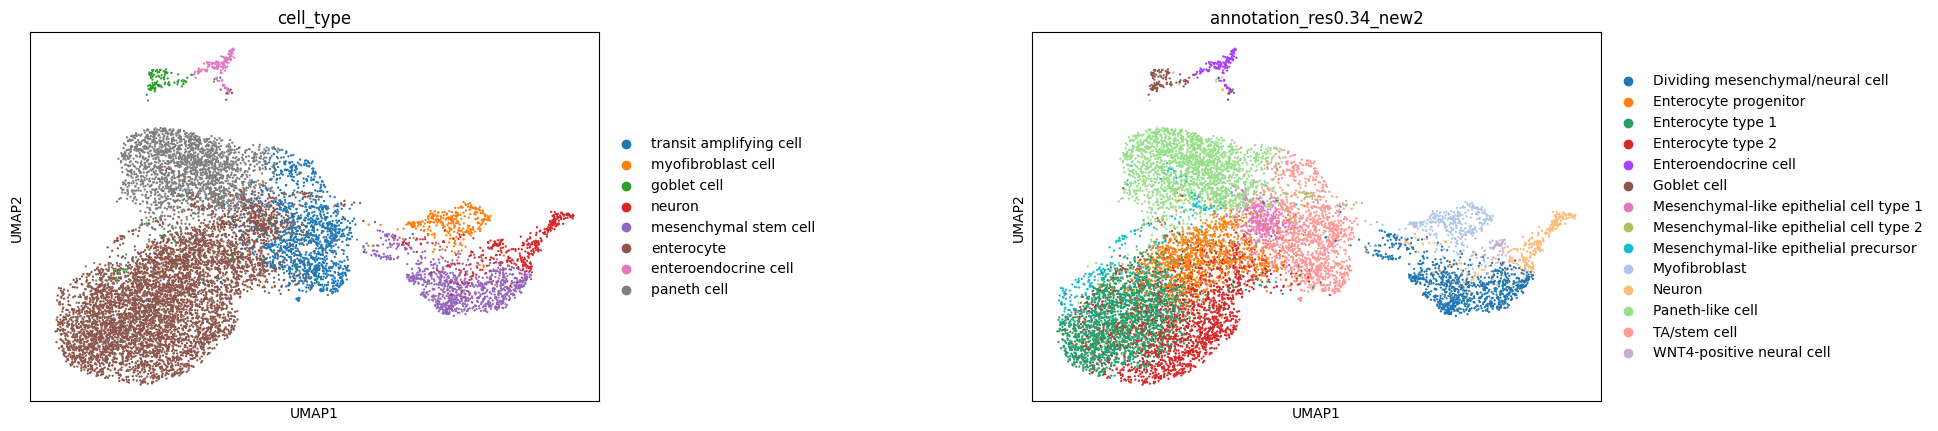

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    #sc.pp.neighbors(ref_embed_adata, use_rep="X")
    #sc.tl.umap(ref_embed_adata)
    sc.pl.umap(adata, color=["cell_type", "annotation_res0.34_new2"], wspace = 0.6)

We can also take a look at some markers of the major cell types represented in the dataset.

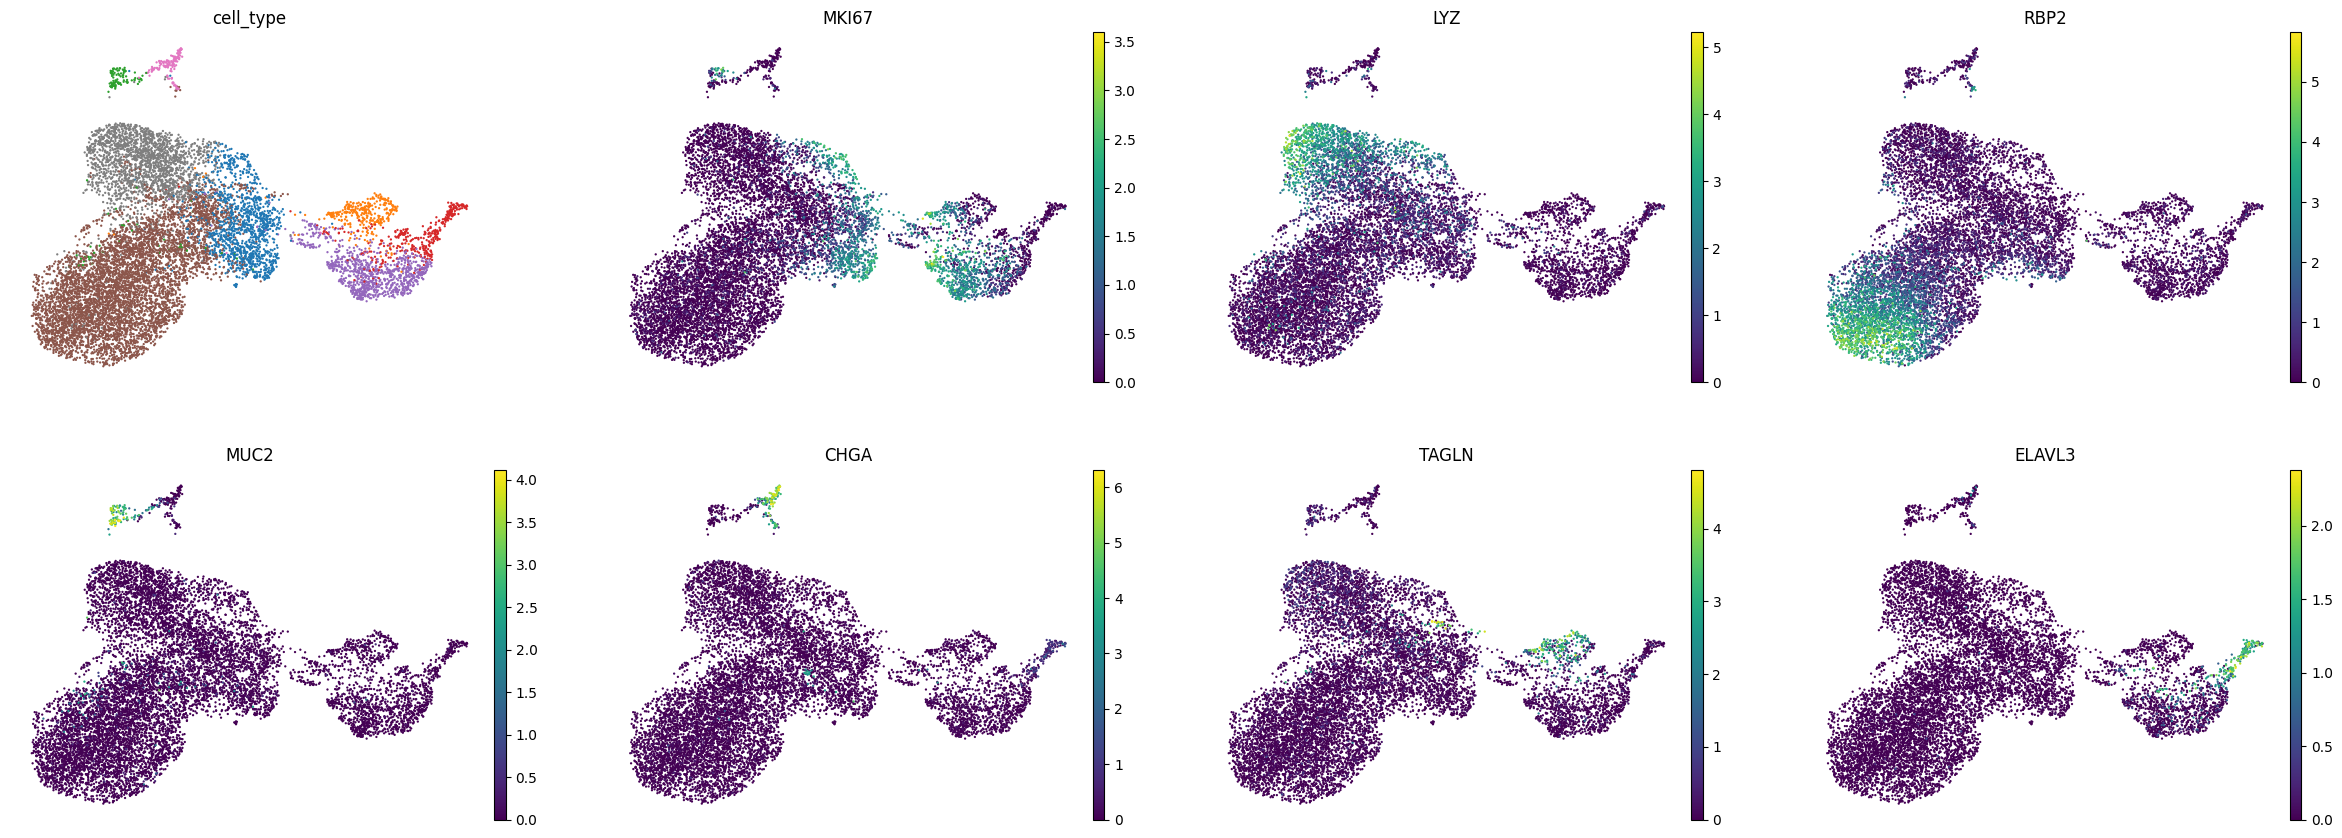

In [ ]:
sc.pl.umap(adata, color=['cell_type', 'MKI67', 'LYZ', 'RBP2', 'MUC2', 'CHGA', 'TAGLN', 'ELAVL3'], frameon=False, use_raw=False, legend_fontsize ="xx-small", legend_loc="none")

## Contact and acknowledgements

We acknowledge the developers of the scGPT model Haotian Qui and Bo Wang. For questions about the model, you can contact the CELLxGENE team via [cellxgene@chanzuckerberg.com](cellxgene@chanzuckerberg.com). If you would like to provide feedback about this tutorial, you can do so with the following [survey](https://airtable.com/appd6ZLxfAOLcfNcs/pag0zfllsEkiI9tq8/form?prefill_colab_link=COLAB&hide_colab_link=true).

## References

Please refer to the following papers for information about:

scGPT: Toward building a foundation model for single-cell multi-omics using generative AI

Cui, H., Wang, C., Maan, H. et al. scGPT: toward building a foundation model for single-cell multi-omics using generative AI. Nat Methods 21, 1470–1480 (2024). https://doi.org/10.1038/s41592-024-02201-0

**The dataset used in this tutorial**

Moerkens, R., Mooiweer, J., Ramírez-Sánchez, A. D., Oelen, R., Franke, L., Wijmenga, C., Barrett, R. J., Jonkers, I. H., & Withoff, S. (2024). An iPSC-derived small intestine-on-chip with self-organizing epithelial, mesenchymal, and neural cells. Cell Reports, 43(7). https://doi.org/10.1016/j.celrep.2024.114247

**CELLxGENE Discover and Census**

CZ CELLxGENE Discover: A single-cell data platform for scalable exploration, analysis and modeling of aggregated data CZI Single-Cell Biology, et al. bioRxiv 2023.10.30; doi: https://doi.org/10.1101/2023.10.30.563174